In [1]:
from datetime import datetime, timedelta
from netCDF4 import Dataset


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import glob

import numpy as np
import math


from netCDF4 import Dataset

import pandas as pd

from metpy.calc import reduce_point_density
import metpy.calc as mpcalc
from metpy.plots import StationPlot, wx_code_to_numeric
from metpy.plots.wx_symbols import sky_cover, current_weather
from metpy.units import units
from metpy.interpolate import interpolate_to_grid, remove_nan_observations
from metpy.io import metar


In [2]:
UNIX_TIME = datetime(1970,1,1,0)




In [3]:
def main():
    global UNIX_TIME
    
    #set times to plot
    start_year  = 2020
    start_month = 8
    start_day   = 14
    start_hour  = 20
    n_hours     = 2
    
    #set plot domain
    lat_min = 40
    lat_max = 52
    lon_min = -102
    lon_max = -86
    
    start_date = datetime(start_year,start_month,start_day,start_hour)
    dts = [start_date + timedelta(hours=i) for i in range(n_hours)]
    
    for dt in dts:
        #get the data
        data = get_data(dt)
        #convert the data to a pandas dataframe
        df = nc2df(data)
        #trim unnecessary data
        df = trimmer(df,lon_min,lon_max,lat_min,lat_max)
        fig = plot_sfc(df,lon_min,lon_max,lat_min,lat_max)
        
        plt.show()
    

In [4]:
def get_data(dt):
    import requests
    import gzip
    import shutil

    #download and extract the data
    base_url = 'https://madis-data.cprk.ncep.noaa.gov/madisPublic1/data/archive/'#2013/11/17/point/metar/netcdf/
    url = f'{base_url}{dt:%Y}/{dt:%m}/{dt:%d}/point/metar/netcdf/{dt:%Y%m%d_%H%M}.gz'
    r = requests.get(url,allow_redirects=True)
    open('temp.nc.gz','wb').write(r.content)
    with gzip.open('temp.nc.gz','rb') as f_in:
        with open('temp.nc','wb') as f_out:
            shutil.copyfileobj(f_in,f_out)
    data=Dataset('temp.nc','r')
    return data


In [5]:
def nc2df(data):
    time = [UNIX_TIME + timedelta(seconds=float(t)) for t in data['timeNominal']]
    lat = data['latitude'][:]
    lat = lat.filled(np.nan)
    lon = data['longitude'][:]
    lon = lon.filled(np.nan)
    temp = data['temperature'][:]
    temp = temp.filled(np.nan)
    temp[temp<100]=np.nan
    temp = (temp-273.15)
    dwpt = data['dewpoint'][:]
    dwpt = dwpt.filled(np.nan)
    dwpt[dwpt<100]=np.nan
    dwpt = (dwpt-273.15)
    wspd = data['windSpeed'][:]
    wspd = wspd.filled(np.nan)
    wspd[wspd>250] = np.nan
    wdir = data['windDir'][:]
    wdir = wdir.filled(np.nan)
    wdir[wdir<0] = np.nan
    gust = data['windGust'][:]
    gust = gust.filled(np.nan)
    gust[gust<0] = np.nan
    pres = data['seaLevelPress'][:]/100.0
    pres = pres.filled(np.nan)
    #pres[pres<900] = np.nan
    #pres[pres>1100] = np.nan
    #print(pres)
    name = data['stationName'][:]
    name = [i.tostring().decode()[:4] for i in name]
    sky_cov = data['skyCover'][:]
    sky_cov = [(i[0].tostring().decode()).rstrip('\x00') for i in sky_cov]
    sky_cvr = np.zeros(len(sky_cov),dtype=int)
    clr_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="CLR"]
    sky_cvr[clr_inds] = 0
    few_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="FEW"]
    sky_cvr[few_inds] = 2
    sct_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="SCT"]
    sky_cvr[sct_inds] = 4
    bkn_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="BKN"]
    sky_cvr[bkn_inds] = 6
    ovc_inds = [n for n,i in zip(range(len(sky_cov)),sky_cov) if i=="OVC"]
    sky_cvr[ovc_inds] = 8
    wx = data['presWeather'][:]
    pres_wx = np.zeros(len(lat))
    wx = [(i.tostring().decode()).rstrip('\x00') for i in wx]
    for i in range(len(wx)):
        this_wx = wx[i].split()
        if this_wx == []:
            pres_wx[i] = 0
            continue
        pres_wx[i] = wx_code_to_numeric(this_wx)[0]
    pres_wx = pres_wx.astype(int)
    #print([wx_code_to_numeric(i) for i in wx])
    #sky_cov[sky_cov=="CLR"] = 0.0
    #sky_cov[sky_cov=="FEW"] = 0.25 
    #print(wx)
    
    u,v = mpcalc.wind_components((wspd*units('m/s')).to('knots'),wdir*units.degree)

    #u = np.abs(wspd) * np.cos(np.deg2rad(270-wdir))
    #u[np.abs(u)>250] = np.nan
    #v = np.abs(wspd) * np.sin(np.deg2rad(270-wdir))
    #v[np.abs(v)>250] = np.nan

    #u=u*units['kts']
    #v=v*units['kts']

    df = pd.DataFrame(np.transpose(np.array([time,name,name,lon,lat,u,v,temp,dwpt,pres,sky_cvr,pres_wx])),
                      columns = ['time','id','name','lon','lat','u','v','temp','dwpt','pres','sky_cvr','wx'])
    
    return df


In [6]:
def trimmer(df,lon_min,lon_max,lat_min,lat_max):
    print('  drop data outside of domain')
    to_drop = df[(df['lat'] > lat_max+10) | (df['lat'] < lat_min-10) | (df['lon'] > lon_max+10) | (df['lon'] < lon_min-10)].index
    print('    dropped %i observations'%len(to_drop))
    df.drop(to_drop,inplace=True)
    df.set_index(['time','id'],inplace=True)
    return df


In [7]:
def plot_sfc(df,lon_min,lon_max,lat_min,lat_max):
    proj = ccrs.LambertConformal(central_latitude=(lat_min+lat_max) / 2,
                                     central_longitude=(lon_min+lon_max) / 2)

    slpdf = df.dropna(subset=['pres'],inplace=False)
    
    point_locs = proj.transform_points(ccrs.PlateCarree(),df['lon'].values,df['lat'].values)
    point_locs_slp = proj.transform_points(ccrs.PlateCarree(),slpdf['lon'].values,slpdf['lat'].values)

    xp,yp,null = point_locs_slp.T
    
    
    slpgridx, slpgridy, slp = interpolate_to_grid(xp,yp,slpdf['pres'],interp_type='cressman',minimum_neighbors=1,hres=10000,search_radius=100000)
    
    df = df[reduce_point_density(point_locs,90000.)]
    
    fig=plt.figure(figsize=(11,6.5),dpi=300)
    ax = fig.add_subplot(1,1,1,projection=proj)
    ax.add_feature(cfeature.STATES)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent((lon_min,lon_max,lat_min,lat_max))

    stationplot = StationPlot(ax,df['lon'].values,df['lat'].values,clip_on=True, transform=ccrs.PlateCarree(),fontsize=8)
    #stationplot.plot_text((2.1,0),df['name'].values,fontsize=4,color='gray')
    stationplot.plot_parameter('NW',df['temp']*(9.0/5.0)+32.0,color='darkred',fontsize=8)
    stationplot.plot_parameter('NE',df['pres'],color='black',formatter=lambda v: format(10 * v, '.0f')[-3:],fontsize=8)
    stationplot.plot_parameter('SW',df['dwpt']*(9.0/5.0)+32.0,color='darkgreen',fontsize=8)
    stationplot.plot_barb(np.array(df['u'].values,dtype=np.float),np.array(df['v'].values,dtype=np.float),linewidth=0.7,length=6)
    cs = plt.contour(slpgridx,slpgridy,slp,colors='k',levels=list(range(900,1034,4)),linewidths=1)
    plt.clabel(cs, inline=1, fontsize=8, fmt='%i')
    stationplot.plot_symbol('C',df['sky_cvr'].values,sky_cover)
    stationplot.plot_symbol('W',df['wx'].values,current_weather,fontsize=12)
    #plt.suptitle(dt_str)
    fig.tight_layout()
    
    return fig

/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_34219/4084283552.py:30: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  name = [i.tostring().decode()[:4] for i in name]
/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_34219/4084283552.py:32: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sky_cov = [(i[0].tostring().decode()).rstrip('\x00') for i in sky_cov]
/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_34219/4084283552.py:46: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  wx = [(i.tostring().decode()).rstrip('\x00') for i in wx]


  drop data outside of domain
    dropped 4285 observations


/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_34219/4233933242.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  stationplot.plot_barb(np.array(df['u'].values,dtype=np.float),np.array(df['v'].values,dtype=np.float),linewidth=0.7,length=6)


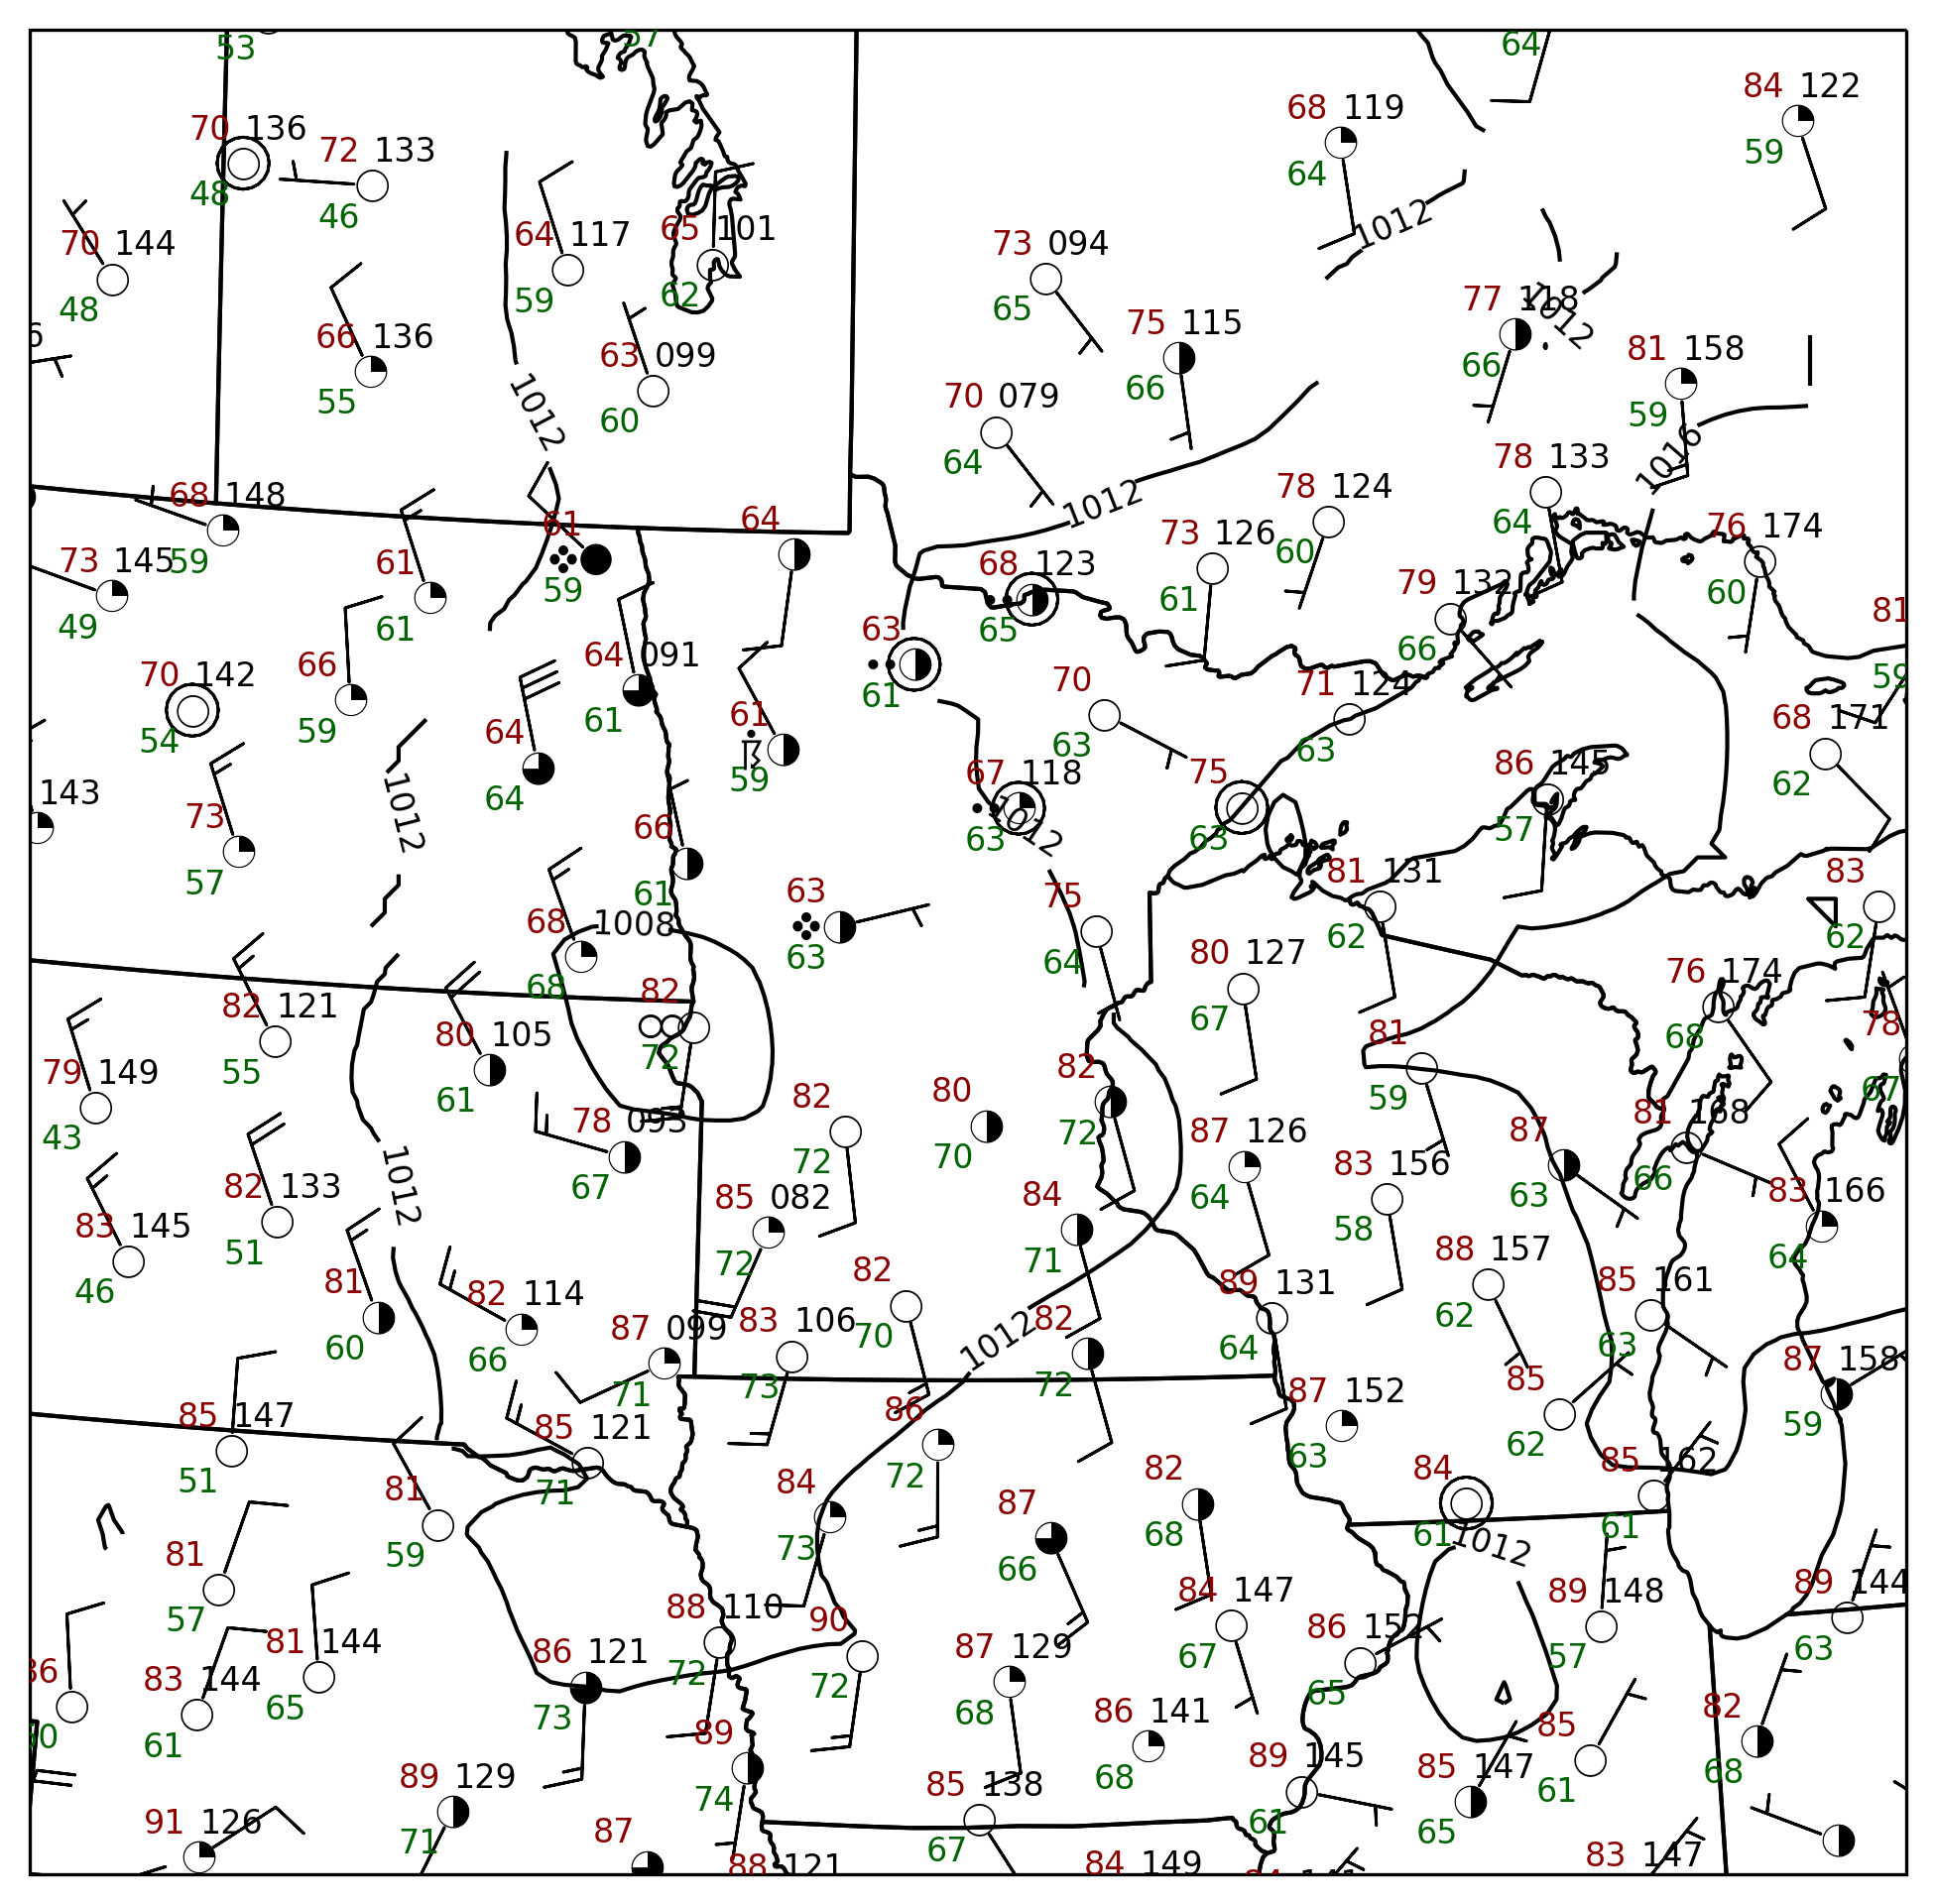

/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_34219/4084283552.py:30: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  name = [i.tostring().decode()[:4] for i in name]
/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_34219/4084283552.py:32: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  sky_cov = [(i[0].tostring().decode()).rstrip('\x00') for i in sky_cov]
/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_34219/4084283552.py:46: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  wx = [(i.tostring().decode()).rstrip('\x00') for i in wx]


  drop data outside of domain
    dropped 4271 observations


/var/folders/06/psvnwwys3wb8jvz_dtrft5080000gn/T/ipykernel_34219/4233933242.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  stationplot.plot_barb(np.array(df['u'].values,dtype=np.float),np.array(df['v'].values,dtype=np.float),linewidth=0.7,length=6)


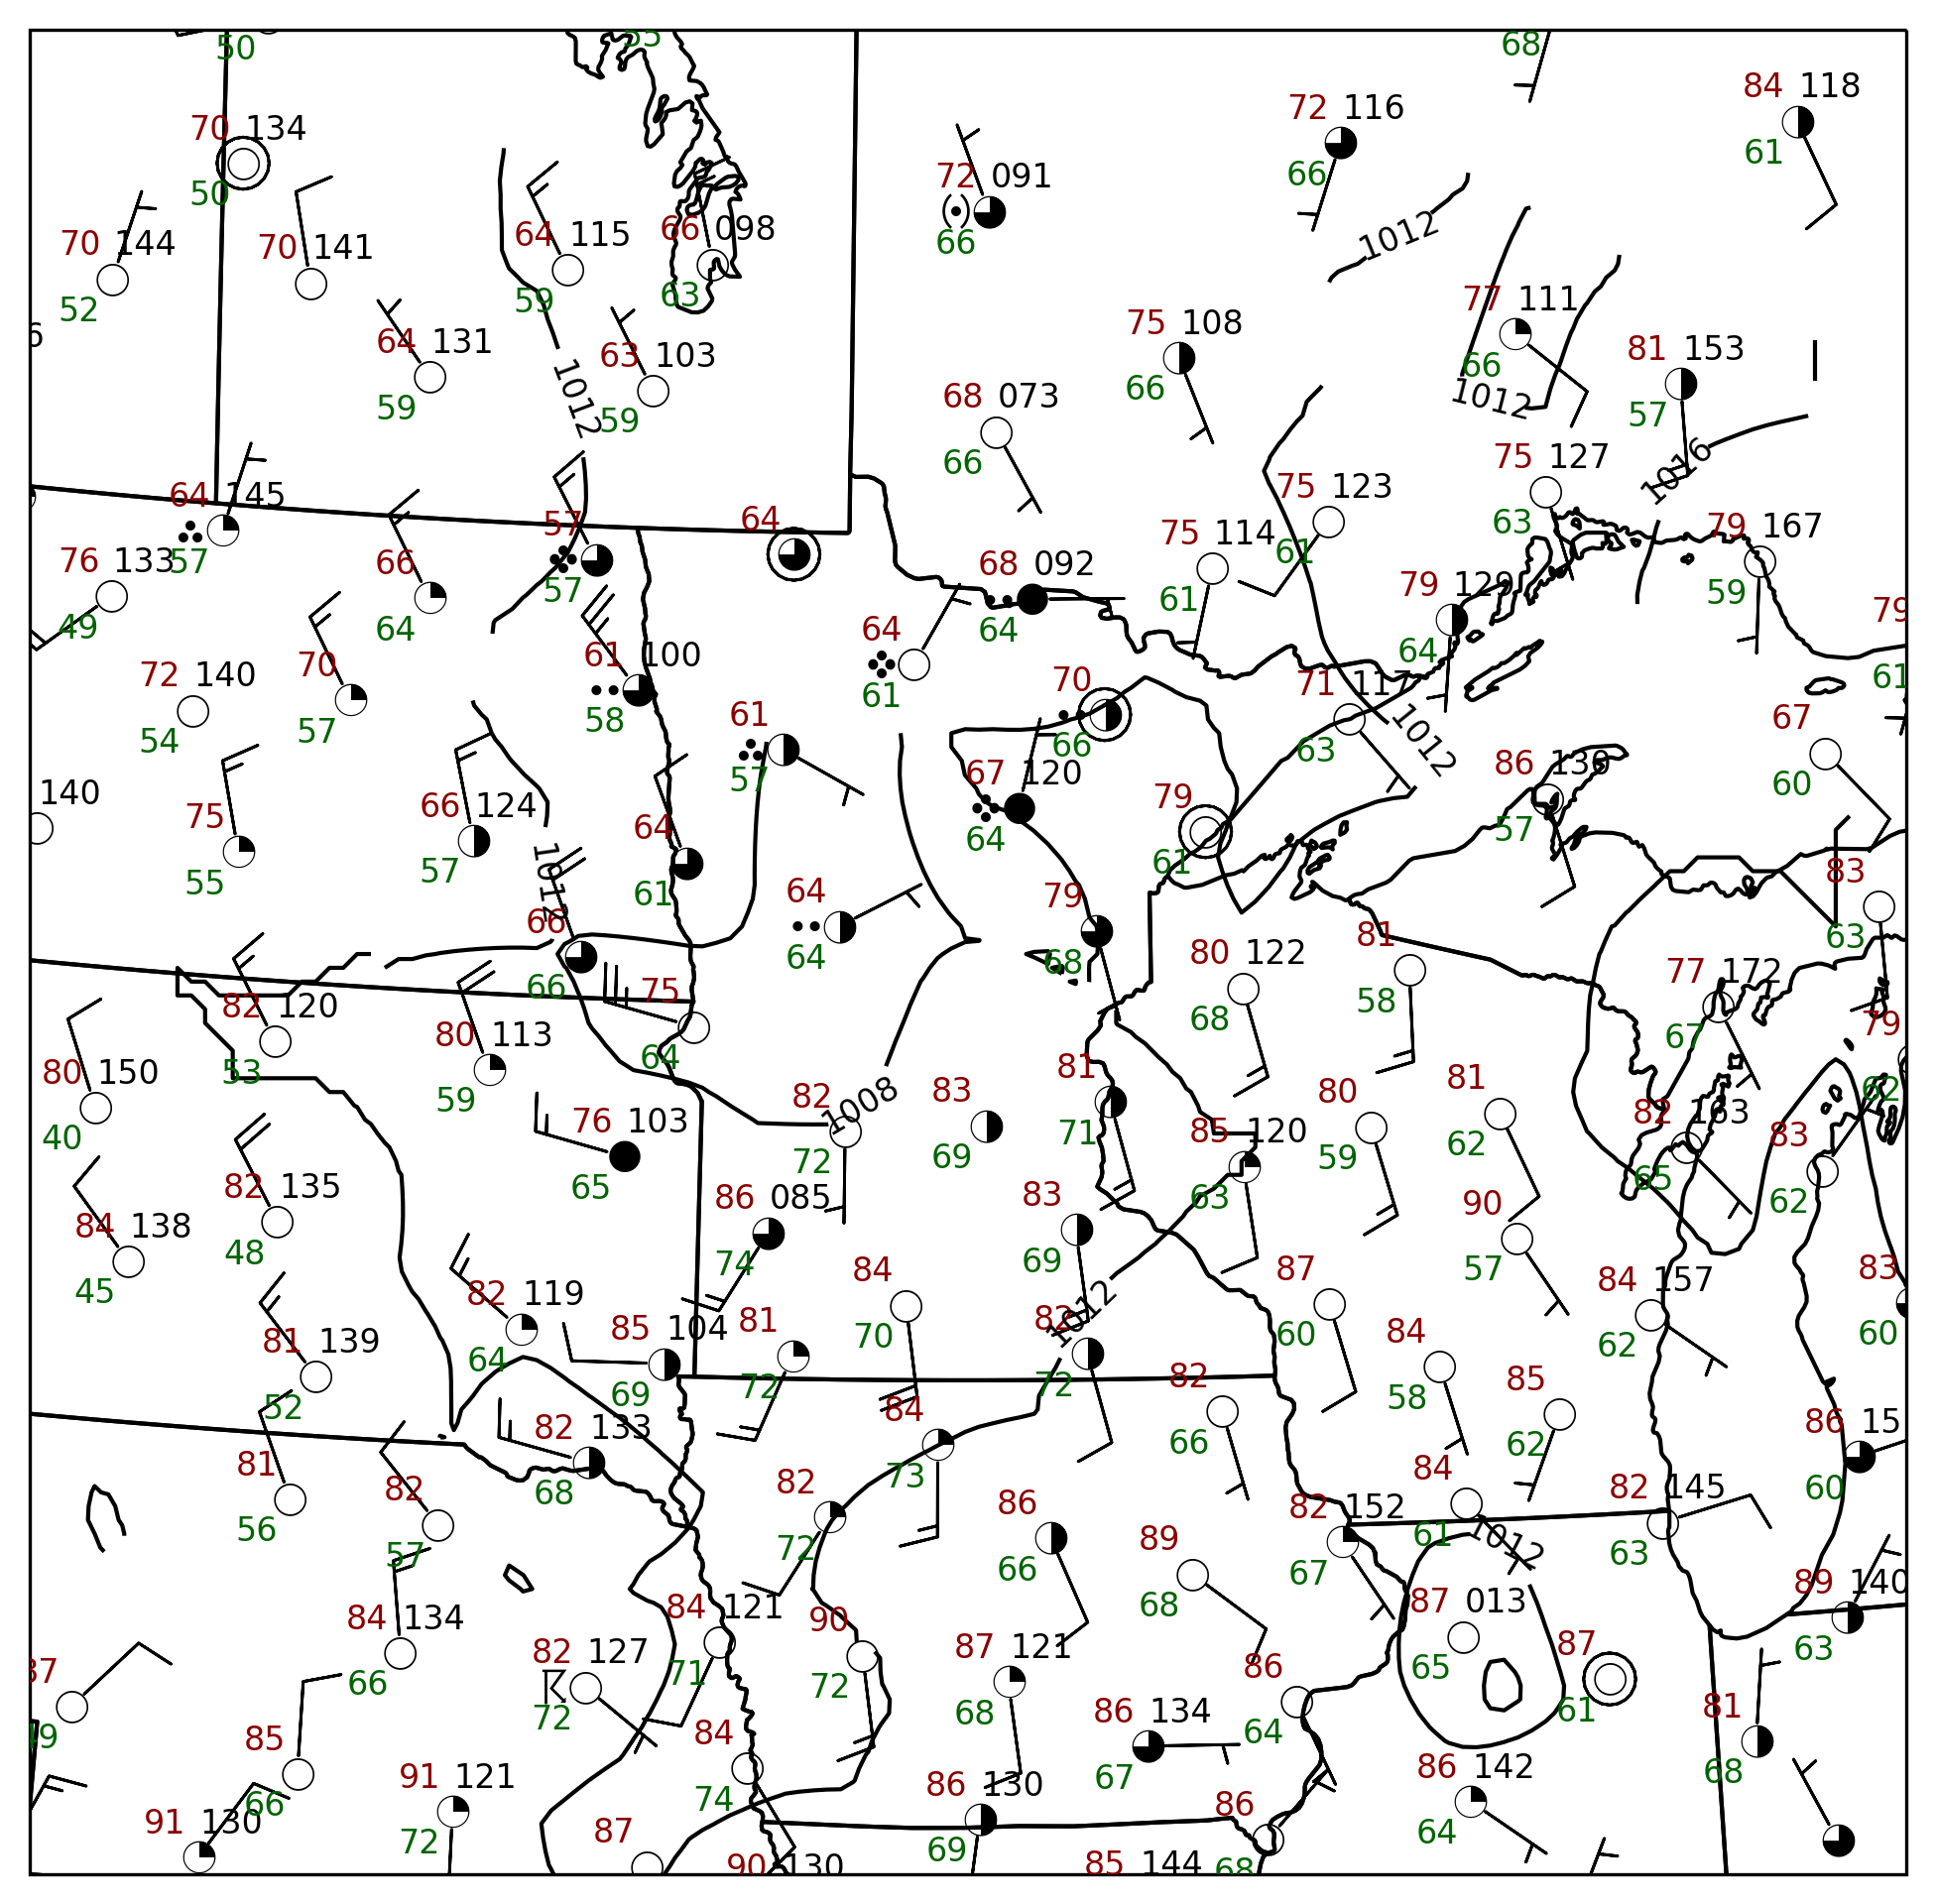

In [8]:
if __name__ == '__main__':
    main()